In [9]:
import torch
import whisper
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model = whisper.load_model('tiny')

100%|█████████████████████████████████████| 72.1M/72.1M [00:02<00:00, 25.6MiB/s]


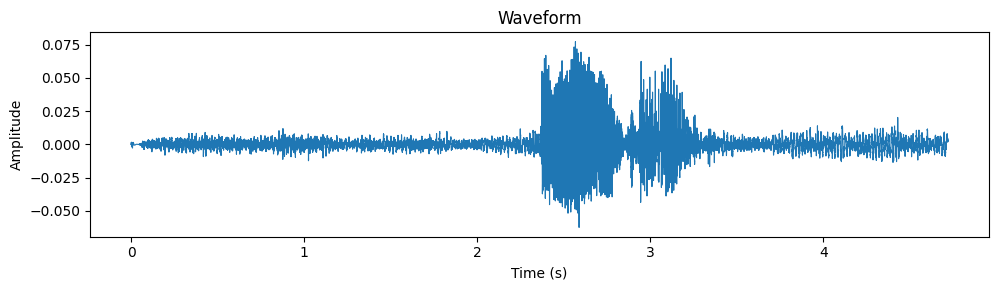

In [21]:
audio = whisper.load_audio("name.wav")
sr = whisper.audio.SAMPLE_RATE          # Whisper always uses 16 kHz
t  = np.arange(audio.shape[-1]) / sr    # seconds

plt.figure(figsize=(10, 3))
plt.plot(t, audio, linewidth=0.8)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

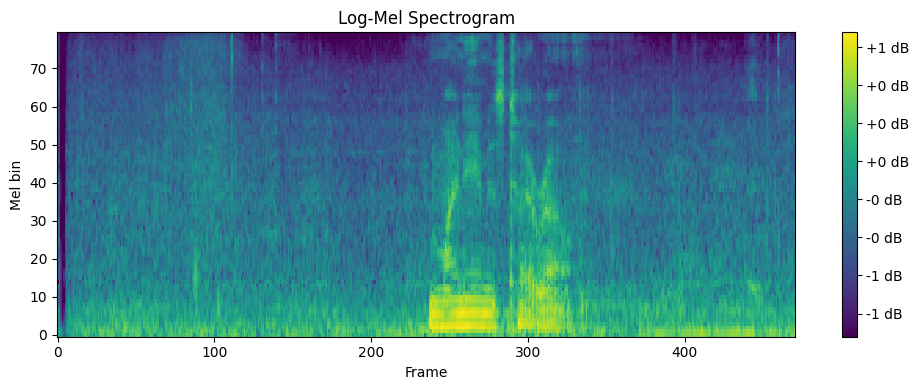

In [16]:
# %%
lg_ml = whisper.log_mel_spectrogram(audio)
mel = lg_ml.numpy()           # (80 mel bins × n_frames) → NumPy for imshow

plt.figure(figsize=(10, 4))
plt.imshow(
    mel,
    origin="lower",           # put 0 Hz at the bottom
    aspect="auto",
    interpolation="nearest"
)
plt.title("Log-Mel Spectrogram")
plt.xlabel("Frame")
plt.ylabel("Mel bin")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [24]:
audio = whisper.pad_or_trim(audio)
lg_ml = whisper.log_mel_spectrogram(audio)
tknsr = whisper.tokenizer.get_tokenizer(multilingual=True)

In [25]:
opt = whisper.DecodingOptions()
res = whisper.decode(model, lg_ml.to(model.device), opt)

In [26]:
res.text

'My name is Tyrone.'

In [29]:
ids = [tknsr.sot, tknsr.language_token, tknsr.transcribe, tknsr.no_timestamps]
ids += tknsr.encode("My name is Tyrone.")
ids += [tknsr.eot]

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()
model.train()
tokens = torch.tensor(ids).unsqueeze(0).to(model.device)
mel = lg_ml.unsqueeze(0).to(model.device)
pred = model(tokens=tokens, mel=mel)


In [31]:
pred.shape

torch.Size([1, 11, 51865])

In [32]:
tokens.shape

torch.Size([1, 11])

In [33]:
trgt = tokens[:, 1:].contiguous()
pred = pred[:, :-1, :].contiguous()

In [34]:
trgt.shape

torch.Size([1, 10])

In [35]:
pred.shape

torch.Size([1, 10, 51865])

In [38]:
trgt.squeeze().shape

torch.Size([10])

In [39]:
tknsr.decode(trgt.squeeze().tolist())

'<|en|><|transcribe|><|notimestamps|>My name is Tyrone.<|endoftext|>'

In [43]:
output_ids = torch.argmax(pred, dim=-1).squeeze().tolist()

In [44]:
output_ids

[50259, 50359, 50363, 1222, 1315, 307, 5569, 26446, 13, 50257]

In [45]:
tknsr.decode(output_ids)

'<|en|><|transcribe|><|notimestamps|> My name is Tyrone.<|endoftext|>'

In [46]:
pred.transpose(1, 2).shape

torch.Size([1, 51865, 10])

In [47]:
loss = criterion(pred.transpose(1, 2), trgt)

In [49]:
loss.item()

1.1597158908843994

In [50]:
optimizer.zero_grad()
loss.backward()
optimizer.step()
model.eval()

Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-3): 4 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=384, out_features=384, bias=True)
          (key): Linear(in_features=384, out_features=384, bias=False)
          (value): Linear(in_features=384, out_features=384, bias=True)
          (out): Linear(in_features=384, out_features=384, bias=True)
        )
        (attn_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1536, out_features=384, bias=True)
        )
        (mlp_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_post): LayerNorm((384,), eps=1e-05,

In [51]:
prd = model(tokens=tokens, mel=mel)
prd = prd[:, :-1, :].contiguous()

In [52]:
loss = criterion(pred.transpose(1, 2), trgt)
loss.item()

1.1597158908843994